<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/06)_%EC%98%88%EA%B8%88_%EC%83%81%ED%92%88_%ED%85%94%EB%A0%88%EB%A7%88%EC%BC%80%ED%8C%85_%EA%B0%80%EC%9E%85_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 예금 상품 텔레마케팅 가입 예측

> **목차**

* 문제상황 및 데이터 살펴보기  
* 문제해결 프로세스 정의  
1) 고객 프로필 조건에 따른 가입률 비교  
2) Reul base 기반 상품 가입 예측  
3) ML 활용 상품 가입 예측

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter05')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter05' ← 변경X
# os.getcwd()

Mounted at /content/drive


## 문제상황 및 데이터 살펴보기  
---
> **시나리오**

```
최근 주식, 코인 투자가 열풍이 불면서 A은행의 정기예금 가입자가 감소하고 있다. 정기예금 가입률이 높았을 때는 Mass 마케팅 형식으로 홍보를  
해도 투자 대비 효율이 좋았지만 현재는 가입률이 떨어지고 있기 때문에 마케팅 비용 투자 대비 효율이 감소하고 있는 상황이다. 마케팅 비용을  
줄이기 위해 정기예금 가입 가능성이 높은 고객군을 추출하고 타겟 마케팅을 수행하고자 한다.
```

> **데이터 살펴보기**

* 고객마다 과거 진행한 캠페인(마케팅)에 대한 이력과, 현재 캠페인에서 수행된 데이터가 존재한다.
* duration은 예측시 제외 (※ 통화 시간에 따라 Y(가입여부) 결정되므로 제외)
* 데이터 명세 ⬇

|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|나이|직업|결혼|교육|신용카드|주택|대출|연락처|마지막 연락 월|마지막 연락 요일|통화시간|캠페인 기간동안 고객연락횟수|이전 캠페인 연락 후 지난일|  

|previous|poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr,employed|y|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|현재 캠페인 전에 연락횟수|이전 마케팅 결과|고용 변동률|소비자 물가 지수|소비자 신뢰 지수|유리보 3개월 비율|직원수|정기예금 가입여부|

In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter06_예금 상품 텔레마케팅 가입 예측/'
df = pd.read_csv(bath + 'chapter06_bank.csv', sep=';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## 문제해결 프로세스 정의
---
> **문제정의**

```
- 정기예금 가입자 감소, 마케팅 비용 투자 대비 효율 저조
```

> **기대효과**

```
정기예금 가입률 증가, 마케팅 비용 투자 대비 효율 증대
```

> **해결방안**

```
- 정기예금 가입 가능성이 높은 타겟 고객군 추출 및 대상 마케팅
- Session 1  
  - 전처리 및 Categorical 변수 탐색  
- Session 2
  - 데이터 탐색 & Rule base 기반 가입률 높은 고객군 추출
- Session 3
  - ML알고리즘 활용 가입 가능성 높은 고객 예측
```

> **성과측정**

```
- 대조군 대비 타겟 고객군 정기예금 가입률
```

> **현업적용**

```
- 매 월 Data mart 생성 후 Model을 활용하여 타겟 고객군 추출
- 마케팅 후 대조군과 비교를 통해 마케팅 효과 모니터링
```

## Session1
## 고객 프로필 조건에 따른 가입률 비교

### Data 전처리

In [3]:
# Data 형태
# 41188 row, 21 col로 구성됨.
print('df', df.shape)

df (41188, 21)


In [4]:
# Data Type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Null 값
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
# Outlier 확인
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [7]:
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [8]:
# 평균 정기예금 가입률 11%
4640/(36548+4640)*100

11.265417111780131

### 범주형 변수 파악
---
* 범주형 변수의 현황 파악  

In [9]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [10]:
df['age'].dtypes

dtype('int64')

In [26]:
# numeric, categorical value 나누기
numeric_list=[]
categorical_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numeric_list.append(i)

In [27]:
print(numeric_list)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [28]:
print(categorical_list)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


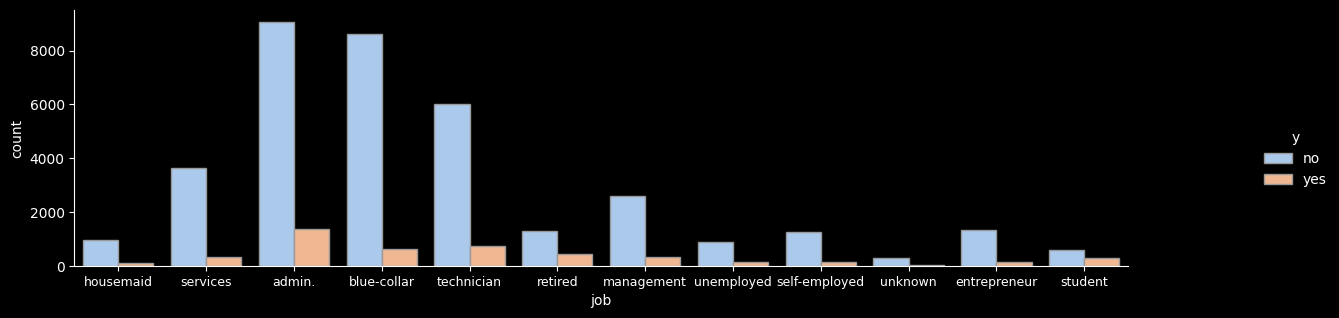

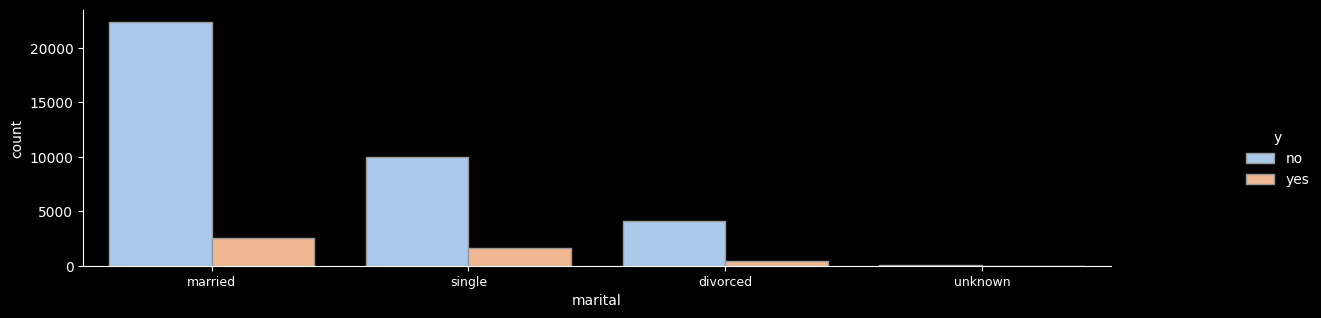

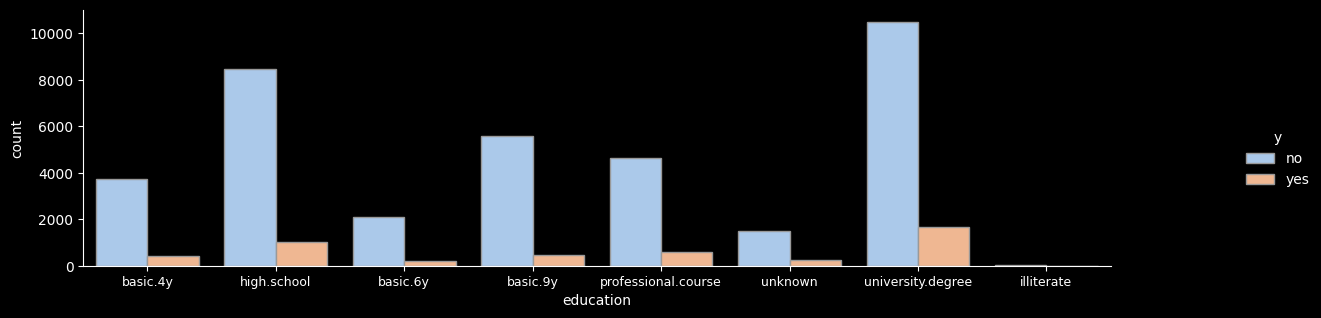

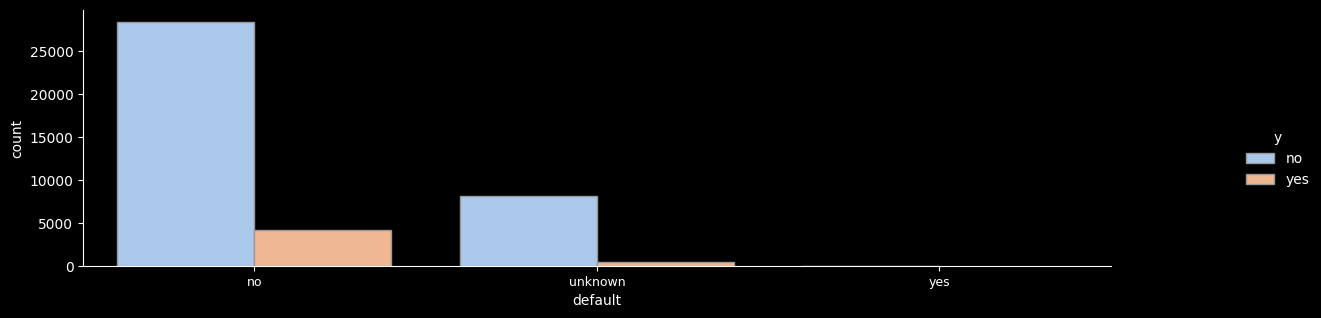

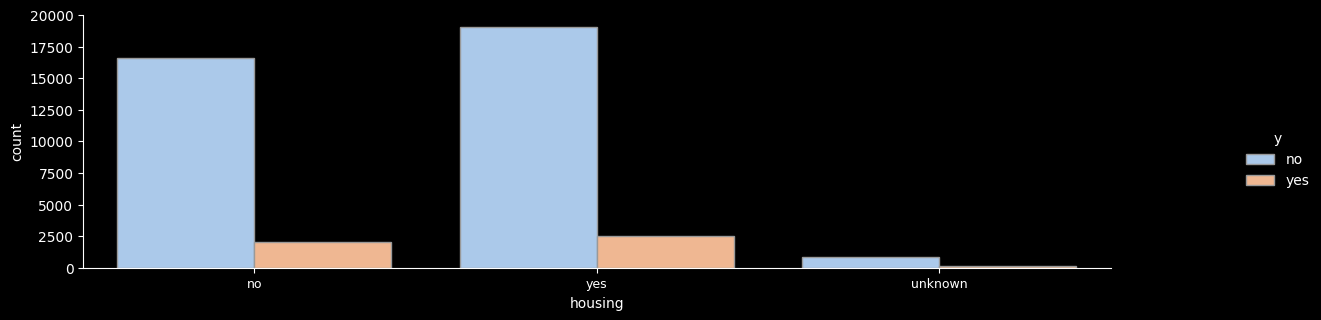

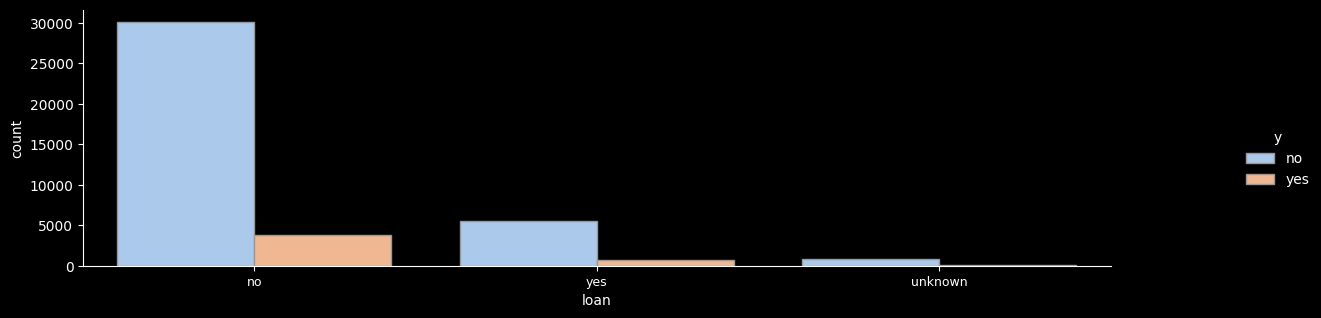

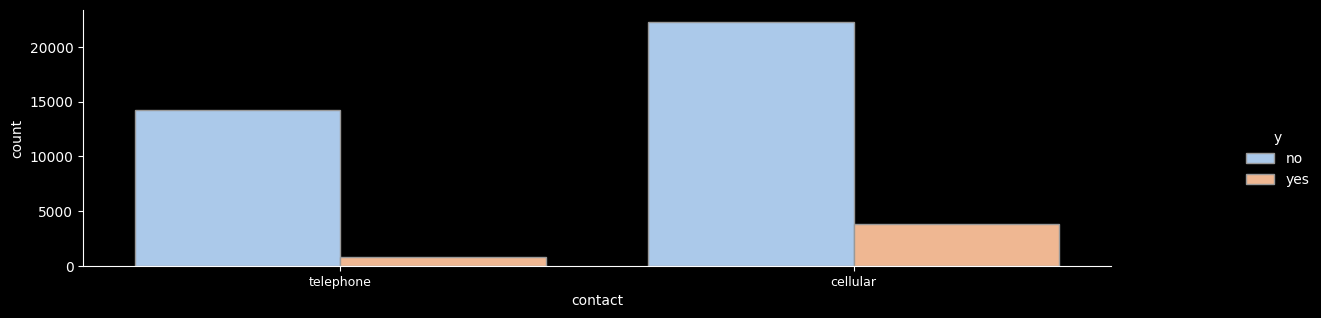

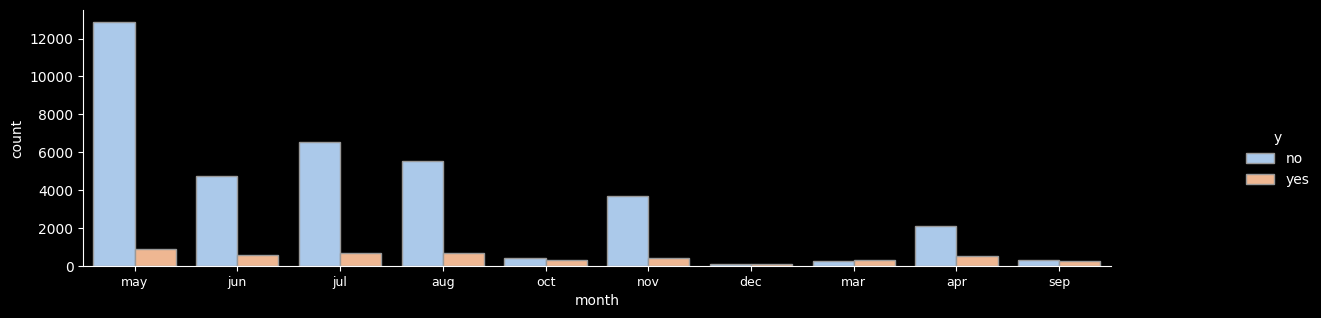

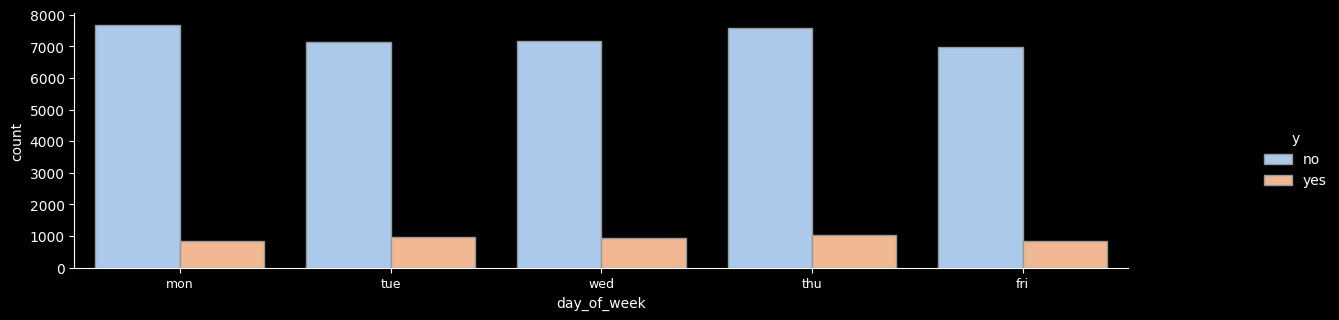

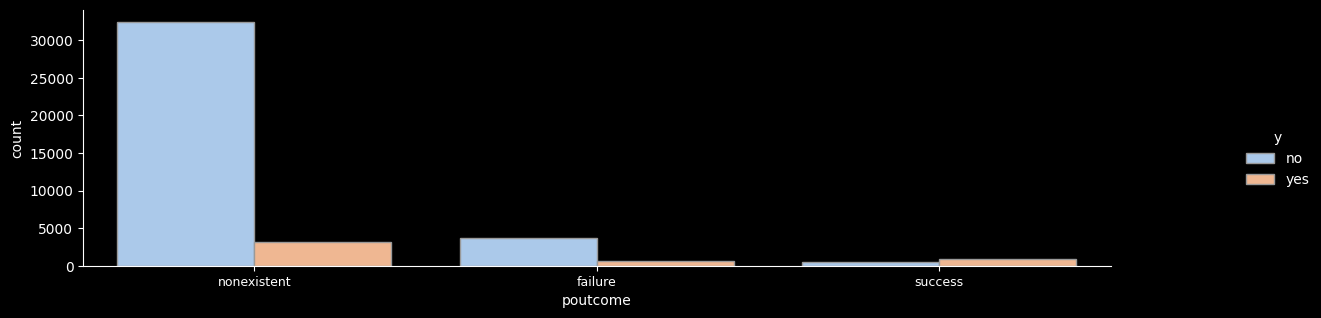

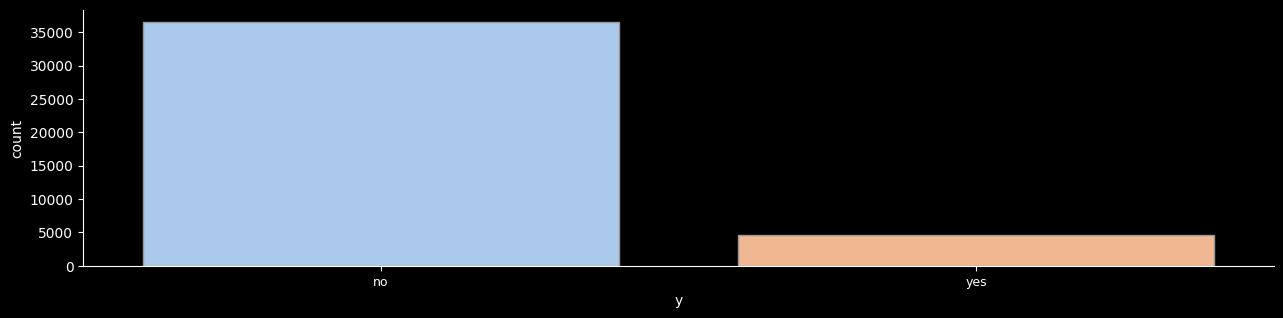

In [34]:
# catplot을 활용하여 Categorical 변수의 구성형태와 정기예금 가입 상황 그래프화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

for i in categorical_list :
  sns.catplot(x=i, hue='y', kind='count', palette='pastel', edgecolor='.6', data=df);
  plt.gcf().set_size_inches(15,3);
  plt.xticks(fontsize=9);

## Session 2
## Rule base 기반 상품 가입 예측  
* 현업에서 경험적 지식으로 얻을 수 있는 노하우 기반  
* 이런 사람들의 가입률이 높겠구나 하는 노하우, 데이터로 검증 후 적용

### 고객 프로필 - 가입률 비교
---

In [40]:
# 고객 job에 따른 정기예금 가입률 비교
df_job = pd.DataFrame(df['y'].groupby(df['job']).value_counts())
df_job.columns=['cnt']
df_job = df_job.reset_index()
df_job.head()

,job,y,cnt
0,admin.,no,9070
1,admin.,yes,1352
2,blue-collar,no,8616
3,blue-collar,yes,638
4,entrepreneur,no,1332


In [41]:
# pivot table을 활용하여 하나의 row로 변환
df_job = pd.pivot_table(df_job, index='job', columns='y', values='cnt')
df_job = df_job.reset_index()
df_job.head()

y,job,no,yes
0,admin.,9070,1352
1,blue-collar,8616,638
2,entrepreneur,1332,124
3,housemaid,954,106
4,management,2596,328


In [42]:
# 가입률(sign_rario)
df_job['sign_ratio']=round((df_job['yes'] / (df_job['yes']+df_job['no']))*100, 1)
df_job

y,job,no,yes,sign_ratio
0,admin.,9070,1352,13.0
1,blue-collar,8616,638,6.9
2,entrepreneur,1332,124,8.5
3,housemaid,954,106,10.0
4,management,2596,328,11.2
5,retired,1286,434,25.2
6,self-employed,1272,149,10.5
7,services,3646,323,8.1
8,student,600,275,31.4
9,technician,6013,730,10.8


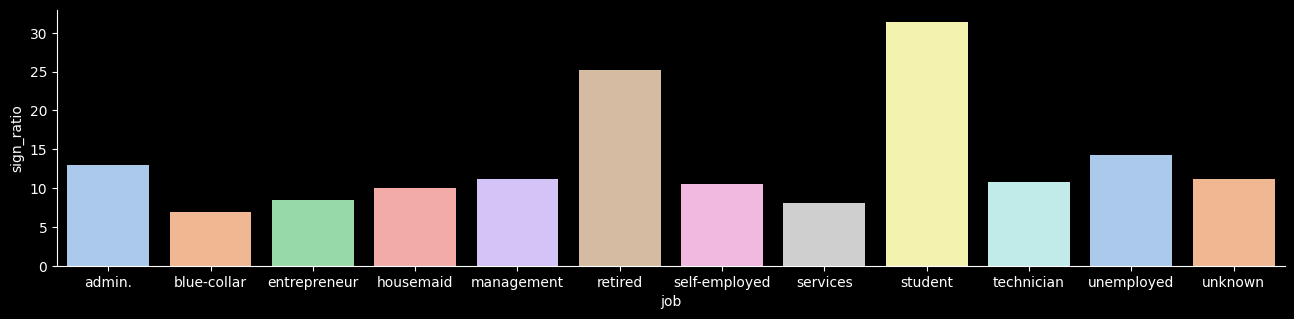

In [43]:
# Student의 가입률이 가장 높고, 다음으로 은퇴 고객의 가입률이 높음.
sns.catplot(x='job', y='sign_ratio', kind='bar', palette='pastel', data=df_job);
plt.rc('xtick', labelsize=20)
plt.gcf().set_size_inches(15,3);

In [46]:
i = 'contact'

# 1단계
df_gp=pd.DataFrame(df['y'].groupby(df[i]).value_counts())
df_gp.columns=['cnt']
df_gp=df_gp.reset_index()

# 2단계
df_gp = pd.pivot_table(df_gp, index=i, columns='y', values='cnt')

# 3단계
df_gp = df_gp.reset_index()

# 4단계
df_gp['sign_ratio']=round((df_gp['yes'] / (df_gp['yes'] + df_gp['no']))*100, 1)
df_gp

y,contact,no,yes,sign_ratio
0,cellular,22291,3853,14.7
1,telephone,14257,787,5.2


In [44]:
categorical_list

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'y']

In [47]:
# 'y'는 예측 값이기 때문에 list에서 삭제
categorical_list.remove('y')

In [48]:
# categorical 변수에 대해서 가입률 비교 모두 진행
# Feature별 가입률이 가장 높은 row에 대해서만 출력

for i in categorical_list :
  df_job=pd.DataFrame(df['y'].groupby(df[i]).value_counts())
  df_job.columns=['cnt']
  df_job=df_job.reset_index()

  df_job = pd.pivot_table(df_job, index=i, columns='y', values='cnt')

  df_job = df_job.reset_index()

  df_job['sign_ratio'] = round((df_job['yes']/(df_job['yes']+df_job['no']))*100, 1)

  df_job = df_job.sort_values(by=['sign_ratio'], ascending=False)

  print(df_job.iloc[0:1, :])
  print('')

y      job   no  yes  sign_ratio
8  student  600  275        31.4

y  marital  no  yes  sign_ratio
3  unknown  68   12        15.0

y   education  no  yes  sign_ratio
4  illiterate  14    4        22.2

y default       no     yes  sign_ratio
0      no  28391.0  4197.0        12.9

y housing     no   yes  sign_ratio
2     yes  19069  2507        11.6

y loan     no   yes  sign_ratio
0   no  30100  3850        11.3

y   contact     no   yes  sign_ratio
0  cellular  22291  3853        14.7

y month   no  yes  sign_ratio
5   mar  270  276        50.5

y day_of_week    no   yes  sign_ratio
2         thu  7578  1045        12.1

y poutcome   no  yes  sign_ratio
2  success  479  894        65.1



### Rule base 가입률
---

In [50]:
# 상위에서 평균 가입률 대비 높았던 조건을 OR 조건으로 새로운 Rule 정의

df_rule = df[ (df['job'] == 'student') |
#(df['marital'] == 'unknown') |
#(df['education'] == 'illiterate') |
#(df['default'] == 'no') |
#(df['housing'] == 'yes') |
#(df['loan'] == 'no') |
(df['contact'] == 'cellular') |
(df['month'] == 'mar') |
(df['day_of_week'] == 'thu') |
(df['poutcome'] == 'success') ]

In [51]:
df_rule['y'].value_counts()

y
no     25143
yes     4091
Name: count, dtype: int64

In [52]:
# rule에 의한 타겟 고객군을 추출했을 때, 평균 14% 가입률을 보임.
4091/(25143+4091)

0.1399397961277964

## Session 3
## ML 활용 상품 가입 예측

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature와 예측하고자하는 값인 Y로 데이터 나눔  
* 학습과 예측을 위한 Train/Test 분할

In [53]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [54]:
# Train/Test data에는 문자 형태로 이루어진 데이터를 input 할 수 없음
# model에서 이해할 수 있는 1, 0으로 Target Data를 변경
import numpy as np
df['y']=np.where(df['y']=='yes', 1,0)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [55]:
df['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [58]:
# 모델링을 학습하기 위한 Feature(X)와 Y 데이터 구분
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X=df.drop(['duration','y'],axis=1)
Y=df['y']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(28831, 19)
(28831,)
(12357, 19)
(12357,)


In [59]:
print(categorical_list)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [60]:
# categorical 변수는 one-hot인코딩 or label 인코딩을 통해 숫자형 변수로 변경함.
# one-hot 인코딩은 차원이 많은 변수에 불리, label인코딩은 회귀관련 알고리즘에서 사용 어려움
from sklearn.preprocessing import LabelEncoder

for col in categorical_list:
  le=LabelEncoder()
  x_train[col]=le.fit_transform(x_train[col])
  x_test[col]=le.transform(x_test[col])

In [61]:
x_train[categorical_list]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
20126,0,1,6,1,0,0,0,1,1,1
25419,9,1,5,0,2,0,0,7,3,1
17112,1,1,0,0,2,0,0,3,0,1
28924,0,1,0,0,0,0,0,0,0,1
15580,1,2,0,1,0,0,1,3,0,1
...,...,...,...,...,...,...,...,...,...,...
39656,4,1,6,0,0,0,0,6,2,2
28723,6,1,6,0,2,0,0,0,2,0
35334,2,1,2,0,2,2,0,6,0,1
4977,1,1,2,0,2,0,1,6,4,1


In [62]:
x_test[categorical_list]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
4984,7,1,3,1,2,0,1,6,4,1
1640,1,1,2,0,0,0,1,6,0,1
35387,9,2,6,0,0,0,0,6,0,0
18665,6,1,5,0,2,0,0,3,2,1
14470,9,1,5,0,2,0,0,3,3,1
...,...,...,...,...,...,...,...,...,...,...
1560,1,1,0,1,2,0,1,6,2,1
1459,0,0,3,0,0,2,1,6,2,1
7329,1,1,7,1,1,1,1,6,0,1
40302,0,1,6,0,2,0,0,3,2,2


### 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [63]:
# 학습
from sklearn.metrics import classification_report
rfc=RandomForestClassifier(random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25583
           1       0.99      0.97      0.98      3248

    accuracy                           1.00     28831
   macro avg       0.99      0.98      0.99     28831
weighted avg       1.00      1.00      1.00     28831

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10965
           1       0.55      0.30      0.39      1392

    accuracy                           0.89     12357
   macro avg       0.73      0.63      0.66     12357
weighted avg       0.87      0.89      0.88     12357



In [64]:
pd.Series(y_pred_test).value_counts()

0    11606
1      751
Name: count, dtype: int64

### Hyper parameter 튜닝
---
* 모델 성능을 올리기 위한 옵션 조절

In [66]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [400],
          'max_depth' : [6,8,10]}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=12345, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=3, n_jobs=-1, scoring='precision')
grid_cv.fit(x_train, y_train)

print('최적 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼파라미터: {'max_depth': 6, 'n_estimators': 400}
최고 예측 정확도: 0.6978


In [67]:
# Best score 기준 재학습
rfc = RandomForestClassifier(n_estimators=400, max_depth=6, random_state=12345, n_jobs=-1)
rfc.fit(x_train, y_train)

y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     25583
           1       0.75      0.21      0.32      3248

    accuracy                           0.90     28831
   macro avg       0.83      0.60      0.64     28831
weighted avg       0.89      0.90      0.88     28831

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.68      0.18      0.29      1392

    accuracy                           0.90     12357
   macro avg       0.79      0.59      0.62     12357
weighted avg       0.88      0.90      0.87     12357



In [68]:
pd.Series(y_pred_test).value_counts()

0    11978
1      379
Name: count, dtype: int64

### 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

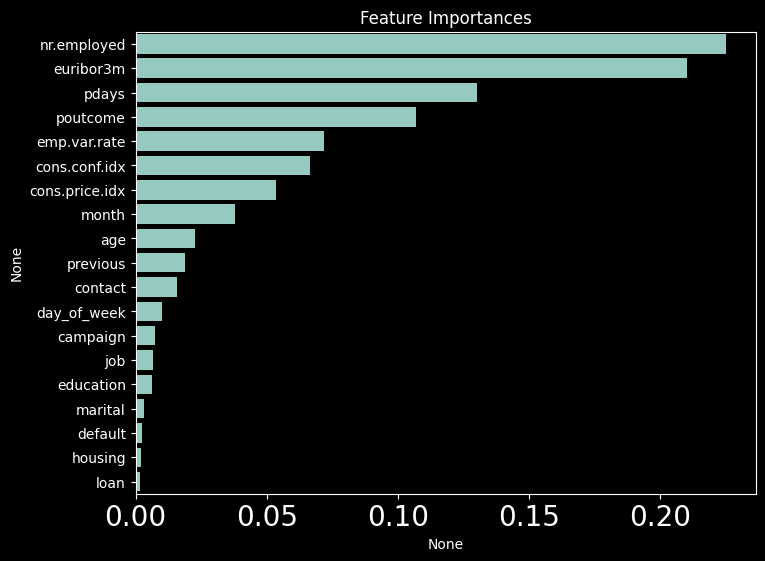

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

###  모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [70]:
import pickle
# 모델 저장
saved_model = pickle.dumps(rfc)

# 모델 Read
clf_from_pickle = pickle.loads(saved_model)